In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             log_loss, confusion_matrix)
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, cv, Pool
from catboost.utils import get_fnr_curve
from lightgbm import LGBMClassifier

from joblib import dump

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Переменные
RANDOM_SEED = 13
TEST_SPLIT = 0.3

* Administrative (int64) - количество посещений административных страниц.
* Administrative_Duration (float64) - общее время, проведенное на административных страницах.
* Informational (int64) - количество посещений информационных страниц.
* Informational_Duration (float64) - общее время, проведенное на информационных страницах.
* ProductRelated (int64) - количество посещений страниц, связанных с продуктами.
* ProductRelated_Duration (float64) - общее время, проведенное на страницах, связанных с продуктами.
* BounceRates (float64) - коэффициент отказов
* ExitRates (float64) - ???показатель выхода
* PageValues (float64) - ???средняя стоимость страницы, которую пользователь посетил.
* SpecialDay (float64) - ???близость времени посещения сайта к особому дню, где 0 означает, что посещение было далеко от специального дня, а 1 означает, что посещение было в специальный день.
* Month (object) - месяц посещения сайта.
* OperatingSystems (int64) - операционная система пользователя.
* Browser (int64) - браузер пользователя.
* Region (int64) - регион пользователя.
* TrafficType (int64) - тип трафика.
* VisitorType (object) - тип посетителя (новый посетитель, вернувшийся посетитель, другое).
* Weekend (bool) - является ли день посещения выходным.
* Revenue (bool) - приносит ли действия пользователя доход (целевая переменная для классификации).

# Данные

In [3]:
# Чтение данных из csv-файла
df = pd.read_csv('../data/online_shoppers_intention.csv')

# Информация по количеству записей и типу данных в каждом столбце
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
# Избавимся от дубликатов
df = df.drop_duplicates()

In [5]:
# Первые и последние 5 строк в датасете
display(df)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [6]:
# Маппинг для столбцов с False/True
for col in ['Weekend', 'Revenue']:
    df.loc[df[col] == False, col] = 0
    df.loc[df[col] == True, col] = 1
    df[col] = df[col].astype(int)

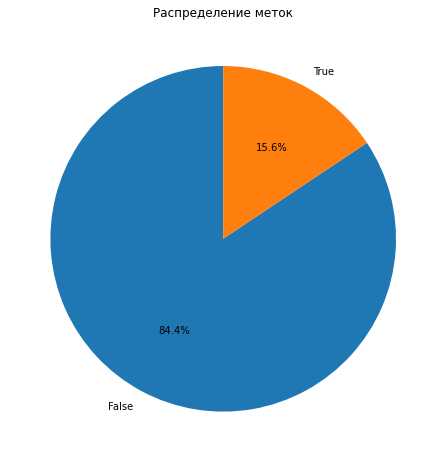

In [7]:
# Графическое отображение распределения меток в датасете
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))
pie_rev = plt.pie(x=df['Revenue'].value_counts(), 
                  labels=['False', 'True'], 
                  autopct='%1.1f%%', 
                  startangle=90,)

title = ax.set_title('Распределение меток')

plt.show()

Для решения проблемы несбалансированного датасета можно воспользоваться некоторыми способами. Некоторые из них:
- Down-sampling - Уменьшение количества примеров большего класса с помощью выбрасивания части примеров (учитывая репрезентативность выборки)
- Synthetic minority over-sampling technique (SMOTE) - Метод одновременного Up-sampling и Down-sampling. Для Up-sampling метод берет случайную точку меньшего класса, находит k ближайших соседей и выводит некоторое усреднение этих точек
- Threshold - можно уменьшить (или увеличить) threshold от стандартных 0.5
- Также можно давать объектам из меньшего класса больший вес в функции потерь, что заставит алгоритм обратить большее внимание на эти точки

In [8]:
sort_month=['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig=px.histogram(df,
                 x='Month',
                 color='Revenue',
                 #pattern_shape='VisitorType',
                 title='Users by month',
                 category_orders=dict(Month=sort_month),
                 #animation_group='VisitorType',
                 text_auto=True)
fig.show()

* Февраль - самый неудачный месяц (мало пользователей, почти без Revenue)
* Май - больше всего пользователей
* Ноябрь - чаще всего пользователи приносят Revenue

* Январь, Август - нет данных

In [9]:
"""
Соотношение пользователей, которые приносят Revenue, в зависимости от
их типа (новый, вернувшийся, другой)
"""
pd.pivot_table(df, index=['VisitorType'],
               values='Revenue', aggfunc=['mean', 'count'])\
  .sort_values(by=('mean', 'Revenue'), ascending=False)

,mean,count
,Revenue,Revenue
VisitorType,,
New_Visitor,0.249262,1693
Other,0.197531,81
Returning_Visitor,0.140926,10431


Новые пользователи чаще других приносят доход

In [10]:
pd.pivot_table(df, index=['SpecialDay'],
               values='Revenue', aggfunc=['mean', 'count'])\
  .sort_values(by=('mean', 'Revenue'), ascending=False)

,mean,count
,Revenue,Revenue
SpecialDay,,
0.0,0.167123,10956
0.6,0.082857,350
0.2,0.078652,178
1.0,0.064935,154
0.4,0.053498,243
0.8,0.033951,324


In [11]:
# Генерация новых признаков
list_ = ['Administrative', 'Informational', 'ProductRelated']
for elem in list_:
    df[f'{elem}_Duration_per_one'] = df[f'{elem}_Duration'].div(df[f'{elem}'])

df.fillna(0, inplace=True)

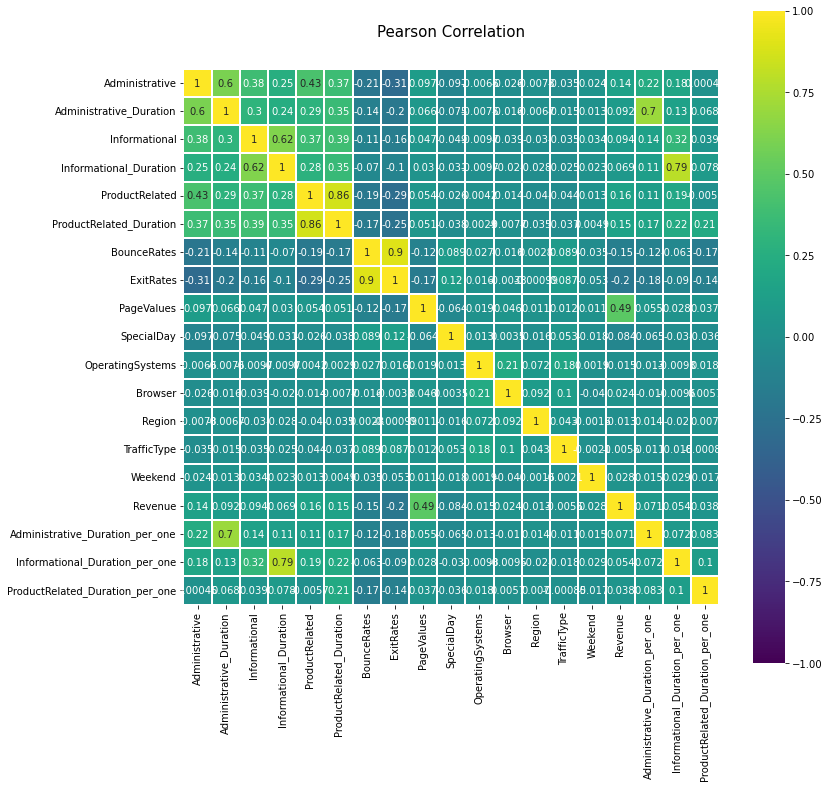

In [12]:
# Матрица корреляции
COLORMAP = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(df.corr(numeric_only=True), linewidths=0.1, vmin=-1, vmax=1,
            square=True, cmap=COLORMAP, linecolor='white', annot=True)
plt.show()

In [13]:
fig = px.box(df, x='PageValues',
             color='Revenue',
             title=f'Distribution of PageValues')
fig.show()

Видно, чем выше значение PageVelues, тем выше вероятность того, что пользователь принесет Revenue

In [14]:
# Сводная статистика для числовых столбцов
df.describe([0.01, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Administrative,12205.0,2.338878,3.330436,0.0,0.00000,0.000000,1.000000,4.000000,14.000000,27.000000
Administrative_Duration,12205.0,81.646331,177.491845,0.0,0.00000,0.000000,9.000000,94.700000,838.704889,3398.750000
Informational,12205.0,0.508726,1.275617,0.0,0.00000,0.000000,0.000000,0.000000,6.000000,24.000000
Informational_Duration,12205.0,34.825454,141.424807,0.0,0.00000,0.000000,0.000000,0.000000,722.379200,2549.375000
ProductRelated,12205.0,32.045637,44.593649,0.0,1.00000,8.000000,18.000000,38.000000,221.000000,705.000000
ProductRelated_Duration,12205.0,1206.982457,1919.601400,0.0,0.00000,193.000000,608.942857,1477.154762,8704.271573,63973.522230
BounceRates,12205.0,0.020370,0.045255,0.0,0.00000,0.000000,0.002899,0.016667,0.200000,0.200000
ExitRates,12205.0,0.041466,0.046163,0.0,0.00125,0.014231,0.025000,0.048529,0.200000,0.200000
PageValues,12205.0,5.949574,18.653671,0.0,0.00000,0.000000,0.000000,0.000000,86.108689,361.763742
SpecialDay,12205.0,0.061942,0.199666,0.0,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000


In [15]:
def metrics_df(y_pred_train, y_train, y_pred, y_test):

    """
    Функция для отображения метрик в виде pandas DataFrame.
    
    >> y_pred_train - прогноз на тренировочной выборке
    >> y_train - фактическое значение на тренировочной выборке
    >> y_pred - прогноз на тестовой выборке
    >> y_test - фактическое значение на тестовой выборке
    """

    metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 
                                    'F1_score', 'Sample_size'])

    facts = [y_train, y_test]
    preds = [y_pred_train, y_pred]
    sample_types = ['train', 'test']
    
    for fact, pred, sample_type in zip(facts, preds, sample_types):

        metrics.loc[sample_type] = {'Accuracy': accuracy_score(fact, pred),
                                    'Precision': precision_score(fact, pred),
                                    'Recall': recall_score(fact, pred),
                                    'F1_score': f1_score(fact, pred),
                                    'Sample_size': int(len(pred))}
    
    display(metrics)
    pass

In [16]:
def show_cm(y_test, y_pred):
    """
    Функция для отображения матрицы ошибок
    
    >> y_pred - прогноз на тестовой выборке
    >> y_test - фактическое значение на тестовой выборке
    """
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (10,8))
    
    classes = ["True Negative","False Positive","False Negative","True Positive"]
    values = ["{0:0.0f}".format(x) for x in cm.flatten()]
    percentages = ["{0:.1%}".format(x) for x in cm.flatten()/np.sum(cm)]
    
    combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
    combined = np.asarray(combined).reshape(2,2)
    
    b = sns.heatmap(cm, annot=combined, fmt='', cmap='YlGnBu')
    b.set(title='Confusion Matrix')
    b.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

    pass

In [17]:
def plot_roc(fpr, tpr, model_name=None, show_=False):

    """
    Функция для отображения ROC-кривой
    
    >> fpr - false positive rate
    >> tpr - true positive rate
    >> model_name - наименование модели
    >> show_ - метка вывода графика
    """

    plt.plot(fpr, tpr,  label=f'{model_name} ROC curve (area = {auc(fpr, tpr):0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC curve')
    if show_: plt.show()

    pass

In [18]:
def try_model(model, X_train, y_train, X_test, y_test,
              model_params=dict(), fit_params=dict(), scaler=None):

    
    if scaler == 'stand':
        pipeline = make_pipeline(StandardScaler(), model(**model_params))
    elif scaler == 'norm':
        pipeline = make_pipeline(MinMaxScaler(), model(**model_params))
    else:
        pipeline = make_pipeline(model(**model_params))
    pipeline.fit(X_train, y_train, **fit_params)

    print(model.__name__)

    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    

    metrics_df(y_pred_train, y_train, y_pred, y_test)

    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])

    print('Log_loss:', log_loss(y_test, pipeline.predict_proba(X_test)[:, 1]))
    
    plot_roc(fpr, tpr, model.__name__)
    
    return pipeline

# Label Encoding

In [19]:
df['Month'].unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [20]:
df['VisitorType'].unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [21]:
df_label = df.copy()

new_values_1 = {'Feb': 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
                'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

new_values_2 = {'Returning_Visitor': 1, 'New_Visitor': 2, 'Other': 3}

df_label['Month'] = df_label['Month'].map(new_values_1)
df_label['VisitorType'] = df_label['VisitorType'].map(new_values_2)

# Деление на трейн/тест
train, test = train_test_split(df_label, stratify=df['Revenue'],
                               random_state=RANDOM_SEED,
                               test_size=TEST_SPLIT)

LogisticRegression


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.878965,0.717579,0.372754,0.490640,8543
test,0.880939,0.750000,0.356643,0.483412,3662


Log_loss: 0.35528514470738337
GaussianNB


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.836240,0.478986,0.537425,0.506526,8543
test,0.835609,0.476780,0.538462,0.505747,3662


Log_loss: 1.1200661697329042
KNeighborsClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.888915,0.781659,0.401946,0.530895,8543
test,0.853359,0.562278,0.276224,0.370457,3662


Log_loss: 1.5089876913385114
DecisionTreeClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.952593,0.907975,0.775449,0.836496,8543
test,0.889405,0.661509,0.597902,0.628099,3662


Log_loss: 1.8517412059984952
RandomForestClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.954232,0.952153,0.744760,0.835783,8543
test,0.905243,0.771084,0.559441,0.648430,3662


Log_loss: 0.23943215224241685
CatBoostClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.964298,0.946320,0.818114,0.877559,8543
test,0.904970,0.739316,0.604895,0.665385,3662


Log_loss: 0.22716025753772107
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
LGBMClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.968746,0.945046,0.849551,0.894758,8543
test,0.901420,0.713131,0.617133,0.661668,3662


Log_loss: 0.2318671228583158


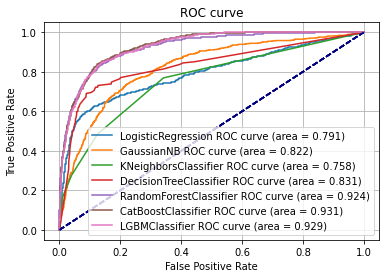

In [22]:
# Модели, по которым будет расчет
models = [LogisticRegression, GaussianNB, KNeighborsClassifier, 
          DecisionTreeClassifier, RandomForestClassifier,
          CatBoostClassifier, LGBMClassifier]

# Цикл перебора заданных моделей
for model in models:
    MODEL_PARAMS = dict()
    if model in (DecisionTreeClassifier, RandomForestClassifier,
                   CatBoostClassifier, LGBMClassifier):
        MODEL_PARAMS['random_state'] = RANDOM_SEED
        
        if model in (DecisionTreeClassifier, RandomForestClassifier):
            MODEL_PARAMS['max_depth'] = 10
        if model in (CatBoostClassifier, LGBMClassifier):
            MODEL_PARAMS['verbose'] = 0
    
    try_model(model,
              train.drop(columns=['Revenue']), train['Revenue'],
              test.drop(columns=['Revenue']), test['Revenue'],
              MODEL_PARAMS)

# One-Hot Encoding

In [23]:
df_one_hot = pd.get_dummies(df, columns=['Month', 'VisitorType', 'OperatingSystems',
                                         'Browser', 'Region', 'TrafficType'])

# Деление на трейн/тест
train, test = train_test_split(df_one_hot, stratify=df['Revenue'],
                               random_state=RANDOM_SEED,
                               test_size=TEST_SPLIT)

In [24]:
# Размерность нового датасета
df_one_hot.shape

(12205, 78)

LogisticRegression


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.878380,0.718062,0.366018,0.484879,8543
test,0.878482,0.732601,0.349650,0.473373,3662


Log_loss: 0.43125150603914475
GaussianNB


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.745406,0.344802,0.697605,0.46150,8543
test,0.734025,0.327320,0.666084,0.43894,3662


Log_loss: 1.9018164211415918
KNeighborsClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.889500,0.785714,0.403443,0.533136,8543
test,0.852813,0.559567,0.270979,0.365135,3662


Log_loss: 1.5364680352574562
DecisionTreeClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.952125,0.906936,0.773204,0.834747,8543
test,0.887766,0.664622,0.568182,0.612630,3662


Log_loss: 1.5894294078858537
RandomForestClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.934917,0.975610,0.598802,0.742115,8543
test,0.895685,0.829861,0.417832,0.555814,3662


Log_loss: 0.2598060493094749
CatBoostClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.960670,0.934783,0.804641,0.864843,8543
test,0.905516,0.740426,0.608392,0.667946,3662


Log_loss: 0.22474865049595366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
LGBMClassifier


,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.969566,0.948333,0.851796,0.897476,8543
test,0.904424,0.729339,0.617133,0.668561,3662


Log_loss: 0.22771980640049122


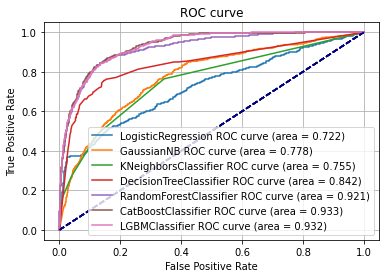

In [25]:
# Модели, по которым будет расчет
models = [LogisticRegression, GaussianNB, KNeighborsClassifier, 
          DecisionTreeClassifier, RandomForestClassifier,
          CatBoostClassifier, LGBMClassifier]

# Цикл перебора заданных моделей
for model in models:
    MODEL_PARAMS = dict()
    if model in (DecisionTreeClassifier, RandomForestClassifier,
                   CatBoostClassifier, LGBMClassifier):
        MODEL_PARAMS['random_state'] = RANDOM_SEED
        
        if model in (DecisionTreeClassifier, RandomForestClassifier):
            MODEL_PARAMS['max_depth'] = 10
        if model in (CatBoostClassifier, LGBMClassifier):
            MODEL_PARAMS['verbose'] = 0
    
    try_model(model,
              train.drop(columns=['Revenue']), train['Revenue'],
              test.drop(columns=['Revenue']), test['Revenue'],
              MODEL_PARAMS)

Незначительно, но все же удалось повысить метрики на лучших из выбранных моделей(CatBoost, LightGBM), однако увеличили объем данных в 3 раза

# Target Encoding

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12205 entries, 0 to 12329
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Administrative                   12205 non-null  int64  
 1   Administrative_Duration          12205 non-null  float64
 2   Informational                    12205 non-null  int64  
 3   Informational_Duration           12205 non-null  float64
 4   ProductRelated                   12205 non-null  int64  
 5   ProductRelated_Duration          12205 non-null  float64
 6   BounceRates                      12205 non-null  float64
 7   ExitRates                        12205 non-null  float64
 8   PageValues                       12205 non-null  float64
 9   SpecialDay                       12205 non-null  float64
 10  Month                            12205 non-null  object 
 11  OperatingSystems                 12205 non-null  int64  
 12  Browser           

In [27]:
cat_features = [10, 11, 12, 13, 14, 15]

# Деление на трейн/тест
train, test = train_test_split(df, stratify=df['Revenue'],
                               random_state=RANDOM_SEED,
                               test_size=TEST_SPLIT)

In [31]:
def CB(X_train, y_train, X_test, y_test, params=dict()):
    
    clf = CatBoostClassifier(**params)

    clf.fit(X_train, y_train,
            eval_set=(X_test, y_test), 
            cat_features=cat_features,
            early_stopping_rounds=100,
            plot=True,
            verbose=0)
    
    # Выбор вероятности, начиная с которой относим к классу 1
    clf.set_probability_threshold(0.2)
    
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)    

    metrics_df(y_pred_train, y_train, y_pred, y_test)
    
    # Дамп модели
    dump(clf, '../models/CatBoost', compress=9)

    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    thresholds, fnr = get_fnr_curve(curve=(fpr, tpr, thresholds))

    plt.figure(figsize=(16, 9))
    lw = 2
    
    plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
    plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Error Rate', fontsize=16)
    plt.title('FPR-FNR curves', fontsize=20)
    plt.legend(loc='lower left')
    plt.show()

    plot_roc(fpr, tpr, 'CatBoost', show_=True)

    print('Log_loss:', log_loss(test['Revenue'], 
                                clf.predict_proba(X_test)[:, 1]))
    
    # Вывод матрицы ошибок
    show_cm(y_test, y_pred)
    
    # Вывод важности признаков
    df_imp = pd.DataFrame({'feature': X_train.columns, 'coef': clf.feature_importances_})
    df_imp.loc[:, 'coef'] = df_imp.loc[:, 'coef'].div(df_imp['coef'].max())
    df_imp = df_imp.sort_values(by=['coef'], ascending=False).reset_index(drop=True)
    
    display(df_imp)

    pass

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Accuracy,Precision,Recall,F1_score,Sample_size
train,0.892778,0.610294,0.869760,0.717284,8543
test,0.874932,0.568510,0.826923,0.673789,3662


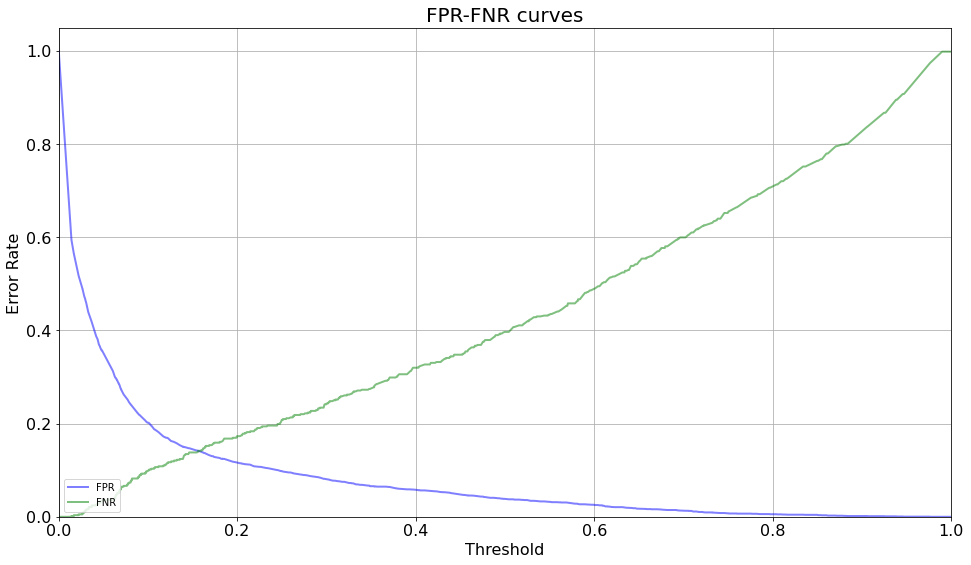

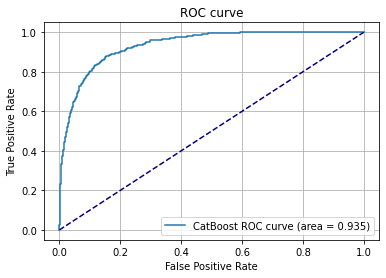

Log_loss: 0.22239753473046034


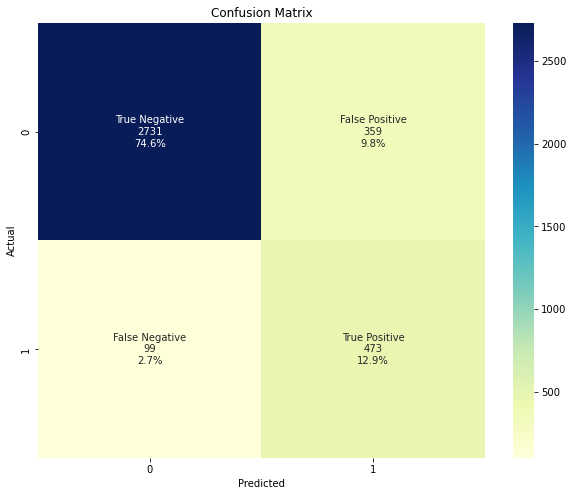

,feature,coef
0,Month,1.000000
1,PageValues,0.903551
2,TrafficType,0.141379
3,ProductRelated_Duration,0.137595
4,ExitRates,0.127224
5,ProductRelated,0.123278
6,BounceRates,0.108608
7,Administrative_Duration_per_one,0.093301
8,VisitorType,0.091867
9,Administrative_Duration,0.089614


In [32]:
CB(train.drop(columns=['Revenue']), train['Revenue'],
   test.drop(columns=['Revenue']), test['Revenue'],
   params={
       'n_estimators': 3000,
       'eval_metric': 'AUC',
       'learning_rate': 0.03,
       'random_state': RANDOM_SEED,
       'custom_loss': ['AUC', 'F1'],
   })

Вероятно, что для интернет магазина важнее не успустить тех посетителей, которые принесут Revenue, поэтому threshold = 0.2

Однако, точную цель для разработки модели нужно уточнить 